# Clase en cuarentena número 3

A continuación, un to-do list de lo que se plantea hacer en esta sesión
- Diagnostico de gelman rubin
- Triangle plot se puede hacer con pandas pero la maestra usa: Corner y getdist
- Histogramas con los puntos de todas las cadenas
- Incluir el prior

**Las siguientes notas de texto fueron tomadas del repositorio de Github de mi amigo [Missael](https://github.com/DCIDA2019/da2020-GabrielMissael/blob/master/Semana10_casa/Actividad_semana10.ipynb).**
**Nota: El estilo de codificación de ese repositorio es más limpio y explícito que este, se tratará de imitar para mayor claridad de código.**

Se busca que la tasa de aceptación esté contenida en el intervalo [0.2, 0.5], esto expresa cuál es la fraccion de los pasos en la cadena se están aceptando. Si es muy pequeña, se esta avanzando con mucha dificultad, es decir, no está convergiendo; en cambio, si es muy alta, se está recorriendo el espacio de parámetros de manera casí uniforme.

Es recomendable correr cadenas largas, para obtener una nube de probabilidad más mejor y asegurar convergencia, aunque en realidad el número de pasos depende totalmente del tipo de problema que estemos atacando, por ejemplo, del número de parámetros y sus características. También es recomendable correr varias cadenas.

Despues de tener la cadena, es necesario cortar los pasos iniciales hasta que se llegue a la zona de alta probabilidad, lo que se denomina como ***burning***. Para esto nos podemos apoyar de las graficas de valor vs. paso para cada uno de los parametros.

Existen varias condiciones cuantitativas para determianar si una cadena ha convergido o no. Un metodo cuantitativo para conocer si el metodo a convergido es el diagnostico ***Gelman-Rubin.***

Una vez que tenemos la cadena generada y una vez que retiramos el burning, para elegir lo que se va a reportar, debemos tomar la media y tomar la desviacion estandar. Esto es idealmente, en caso de obtener una distribución gaussiana. En caso contrario, depende de que resultado obtengamos; esta 'decición'la podemos apoyar graficando todos los histrogramas 2d y 1d de todos los parametros para visualizar que decisiones serian optimas.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from getdist import plots, MCSamples
import getdist

# - Algoritmos de cálculo

### Definimos el logaritmo del likelihood

In [3]:
def logPrior(parametros):
    '''
    DESCRIPTION: Esta función nos regresa lo que sabemos de nuestros parámetros a priori
    IN = {
        parametros: Los parámetros que estamos analizando
    }
    OUT: El prior
    '''
    
    inf = [3, -2]
    sup = [17, 12]
    p = np.zeros(2)
    
    for i in range(2):
        if inf[i]<parametros[i]<sup[i]:
            p[i] = -1*np.log(sup[i]-inf[i])
        else:
            p[i] = 0
    
    return sum(p)

In [4]:
def logLikelihood(x, y, model, sigma, theta):
    '''
    Descripcion: Esta función mida lo bien que un modelo estadístico se adecúa a unos datos
    para los valores de parámetros desconocidos.
    In = {
        x: Variable independiente a analizar
        y: Variable dependiente a analizar
        model: El modelo con el cual lo estamos comparando
        theta: Los parámetros de este modelo
    }
    OUT: El likelihood
    '''
    # Variable suma empezada en 0
    suma = 0
    # Construimos la suma correspondiente a la fórmula del likelihood proporcionada en las notas de la maestra.
    for i in range(len(x)):
        suma += (y[i] - model(x[i], theta))**2 / sigma[i]**2
    
    return -(0.5) * suma

### Definimos la tasa de aceptación

In [5]:
# Tasa de aceptación
def tasaAceptacion(lista, pasosTotales):
    '''
    Descripción: Función que calcula la razón entre la cantidad de pasos aceptados por el método montecarlo
    y la cantidad de pasos totales
    IN = {
        lista: La lista de la cantidad de pasos aceptados de las n cadenas
        pasos: La cantidad de pasos totales del método
    }
    OUT: Una lista de n elementos con la tasa de aceptación para las n cadenas
    '''
    
    listTasa = []
    for index, accepted in enumerate(lista):
        listTasa.append(accepted/pasosTotales)
    return listTasa

### Método Montecarlo

In [2]:
# Se define el método montecarlo
def montecarlo(x, y, sigmaX, sigmaY, model, initPoints, pasosTotales, logLikelihood, logPrior=0):
    import numpy as np
    # Se asigna una semilla específica para hacer comparaciones con otros repositorios, pero se puede quitar sin problemas
    # Se declaran la cadena llamada "Cadena de Markov" y se define la "Matriz de Markov" para albergar varias cadenas
    # Específicamente serán n cadenas, donde n es la cantidad de puntos iniciales que tenemos
    markovMatrix = []
    markovChain = []
    # Se define una lista para la tasa de aceptación 
    aceptado = []
    # Este ciclo creará las n cadenas (recuerde, una por cada punto)
    for index, point in enumerate(initPoints):
        # Se crea el punto inicial, renombrado como p_old, luego será reemplazado por un p_new
        p_old = point
        # Se crea el logaritmo del likelihood relacionado con el punto inicial
        L_old = logLikelihood(x, y, model, sigmaY, p_old)
        # Realmente lo que nos importa es el Posterior, lo calculamos haciendo lo siguiente:
        logPosterior_old = L_old + logPrior(p_old)
        # Se agrega a la cadena de Markov
        markovChain = [[p_old, logPosterior_old]]
        # los elementos de la cadena aceptado siempre inician en 0
        aceptado.append(0)
        
        # Queremos que el algoritom se ejecute "PasosTotales" número de veces.
        for paso in range(pasosTotales):
            # Se define un nuevo punto de parámetros en una vecindad cercana al punto anterior, escogido de manera aleatoria
            p_new = [punto + sigmaX[index]*np.random.randn() for index, punto in enumerate(p_old)]
            # Se crea el logaritmo del likelihood asociado a este nuevo punto.
            L_new = logLikelihood(x, y, model, sigmaY, p_new)
            # Se crea, de nuevo, el posterior
            logPosterior_new = L_new + logPrior(p_new)
        
            # Condiciones para que el nuevo punto sea acepado
            # Que el nuevo likelihood, sea mayor que el anterior o
            # Que la razón entre nuestros likelihoods sea mayor a un número aleatorio.
            if (logPosterior_new>logPosterior_old or logPosterior_new-logPosterior_old>np.random.randn()):
                # Si es así, agregamos nuestro punto a la cadena de Markov y sustituimos nuestros viejos puntos y 
                # likelihood con los nuevos para repetir el proceso después
                markovChain.append([p_new, logPosterior_new])
                p_old = p_new
                logPosterior_old = logPosterior_new
                # Agregamos uno a la suma para nuestra tasa de aceptación
                aceptado[index] += 1
            else:
                # Si no se cumple lo anterior, aún así guardamos el punto creado, sin embargo ya no sustituimos los puntos
                # anteriores con los nuevos, así se repetirá el ciclo pero con los puntos anteriores
                markovChain.append([p_new, logPosterior_new])
        
        # Cada cadena de markov se guarda en nuestra "Matriz de Markov"
        markovMatrix.append(markovChain)
    # Calculamos la tasa de aceptación
    aceptados = tasaAceptacion(aceptado, pasosTotales)        
    # Regresamos nuestra Matriz de Markov y nuestra tasa de aceptación
    return [markovMatrix, aceptados]
    

### Diagnóstico de Gelman Rubin

In [3]:
def gelmanRubin(cadenas):
    '''
    Descripción: Esta función determina si las cadenas que obtuvimos convergen o no convergen, si el resultado de una o más
    cadenas es mayor a 1.1 entonces dicha cadena no converge
    IN ={
        cadenas: Las cadenas de Markov que deseamos analizar
    }
    OUT: Una lista con el resultado del diagnóstico por cada cadena
    NOTA: Esta función fue deducida de las notas de la maestra
    '''
    # Definimos algunas variables que utilizaremos luego
    # Él número de cadeas
    numeroCadenas = len(cadenas)
    # Cuántos pasos tiene cada cadena
    pasosTotal = len(cadenas[0])
    # Número de parámetros
    numeroParametros = len(cadenas[0][0][0])
    
    # Extraemos cada punto de las cadenas y las separamos en una lista de listas por cadena
    puntos = [[] for x in range(numeroCadenas)]
    [puntos[index].append(paso[0]) for index, cadena in enumerate(cadenas) for paso in cadena]
    puntos = np.array(puntos) # Nota: convertimos a un arreglo de numpy por un paso más adelante
    #print(puntos[0][0][1])
    
    for parametro in range(numeroParametros):
        # Definimos si que es una lista de desviaciones estándar de las cadenas (Empiezan en 0)
        si = np.zeros(numeroCadenas)
        # Definimos una lista para las medias de cada cadena y la llenamos con el valor del parámetro
        media = [[] for x in range(numeroCadenas)]
        [media[index].append(punto[parametro]) for index, cadena in enumerate(puntos) for punto in cadena]
        # Sacamos las medias de cada una de las cadenas para el parametro y las guardamos en una variable llamada mediaFinal
        mediaFinal = [np.average(media[index]) for index, aux in enumerate(media)] 
        #print(mediaFinal)
        
        # Con este pedazo de código, calculamos la varianza para cada una de las cadenas
        for cadena in range(numeroCadenas):
            for paso in range(pasosTotal):
                si[cadena] += (puntos[cadena][paso][parametro]-mediaFinal[cadena])**2
        si /= (pasosTotal - 1)
        
        # Definimos s^2 que usaremos después
        s = sum(si)/numeroCadenas
        
        # Definimos miu como la media de todas las cadenas sobre este parámetro
        miu = np.average(mediaFinal)
        
        # Definimos una variable Bn
        Bn = (sum((mediaFinal - miu)**2))/numeroCadenas
        
        # Creamos la variable sigma
        sigma = ((pasosTotal-1)*s)/pasosTotal + Bn
        
        # Y finalmente calculamos R
        R = (sigma/s)**(1/2)
        print(f'El diagnóstico resultante del parámetro {parametro} es: {R:.6}')

# - Algoritmos de visualización

#### Visualizar las cadenas de markov en este ejemplo de dos parámetros

In [4]:
# Definimos función para ver las cadenas de markov
def verCadenasMarkov(cadenas, realPoint=False, corte=0):
    '''
    Descripcion: Una función que nos ayuda a visualizar las cadenas generadas
    IN = {
        cadenas: Las cadenas generadas con el método Monte Carlo
        realPoint: El punto real si es que lo conocemos
        corte: El burning si es que existe
    }
    Out: Gráfica de nuestras cadenas
    '''
    # Se define el tamaño de nuestra gráfica en estos objetos
    fig, ax0 = plt.subplots(figsize=(5, 5))
    # Extraemos la información de cada una de nuestras cadenas para ser graficados
    for index, cadenita in enumerate(cadenas):
        m = [punto[0] for punto, likelihood in cadenita[corte:]]
        b = [punto[1] for punto, likelihood in cadenita[corte:]]
        likelihoods = [likelihood for punto, likelihood in cadenita]
        # Se grafica punto por punto
        chain_plot = ax0.scatter(m, b, marker = '.', alpha = 0.5, label = f"Cadena {index}")
        
    #Si conocemos el punto real (Es decir, los parámetros reales)
    if(realPoint):
        # Se grafica el punto real (Porque en este caso lo conocemos)
        plt.plot(realPoint[0], realPoint[1], marker = 's', label = 'Valor real', c = 'Black')
        
    # Se agregan las leyendas, los nombres de los ejes y la cuadrícula
    plt.legend()
    ax0.set_xlabel('Pendiente (m)')
    ax0.set_ylabel('Ordenada al origen (b)') 
    ax0.grid()
    plt.show()

#### Visualizar los n parámetros en el número de pasos de la cadena

In [11]:
# Definimos la función para graficar el número de pasos vs los parámetros
def graphParameters(cadena, labels, corte=0):
    '''
        Descripción: Visualizar el valor que tiene cada parámetro por cada paso de la cadena dada.
        IN = {
            cadena: La cadena en donde se analizarán los pasos
            corte: Se revisa si existe algún "burning" o corte para hacer "Zoom"
            labels: Nombre de los ejes
        }
    '''  
    # Definirimos cosas que usaremos después, los nombres de las variables expresan claramente lo que significan
    numeroParametros = len(cadena[0][0])
    listaParametros = [[] for parametro in range(numeroParametros)]
    numeroPasos = len(cadena[corte:])
    graficaNumeroPasos = list(range(corte, len(cadena)))
    
    # Separamos los parámetros en listas, para que no estén "revueltos"
    [listaParametros[index].append(parametro) for parametros in cadena[corte:] for index, parametro in enumerate(parametros[0])]
    
    # Creamos el objeto figura y nuestros axs, además, le quitamos heigh space para que estén juntas y sea más claro.
    fig, ax = plt.subplots(numeroParametros, 1, sharex=True, figsize = (10, 5))
    fig.subplots_adjust(hspace=0)
    
    # Nuestro primera gráfica será el que "carge" con el títitulo
    ax[0].set_title('Valor de los parámetros en cada paso')
    # Tenemos que hacer un for por cada uno de los parámetros que hay
    for index, parametro in enumerate(listaParametros):
        # Sacamos su media para comparar lo que estamos haciendo y si tiene algún tipo de distribución
        media = np.percentile(np.array(parametro), 50)
        # Graficamos cada una de los parámetros y su media
        ax[index].plot(graficaNumeroPasos, parametro)
        ax[index].plot(graficaNumeroPasos, [media for aux in graficaNumeroPasos])
        # Le ponemos nombre y cuadrícula a las gráficas
        ax[index].set_ylabel(labels[index])
        ax[index].grid()
    # Y por útlimo, ponemos el eje y  
    ax[numeroParametros-1].set_xlabel('Número de pasos')
    


#### Gráficas triangulares con getdist

In [12]:
def trianglePlot(cadenas, corte=0, labels=[]):
    '''
    Descricpión: Esta función nos permite visualizar de una manera más atractiva (y más clara) a los parámetros y sus pasos
    en la cadena de markov
    IN = {
        cadena: La cadena de Markov la cual estaremas graficando
        corte: El burning para tener algo más claro
        labels: Los nombres de los parámetros
    }
    Out: Una bonita gráfica
    '''
    # Definimos una variable auxiliar
    numeroParametros = len(cadenas[0][0][0])
    # Si labels no está definido, lo predefinimos como "parametro 1, parametro 2,..."
    if(labels==[]):
        labels = [f"Parámetro{index}" for index in range(numeroParametros)]
    # Definimos el objeto central de getdist
    g = plots.get_subplot_plotter(subplot_size=3)
    # Extraemos todos los puntos        
    data = [paso[0] for cadena in cadenas for paso in cadena[corte:]]
    # Algunas funciones de getdist para graficar
    samples = MCSamples(samples=np.array(data[corte:]), labels=labels, names=labels)
    g.triangle_plot(samples, filled=True, contour_colors=["#00bcd4"], title_limit=1)

#### Histograma en 2D

In [13]:
def plotHist2d(cadenas, parametros, bins=200, labels = ["1","2"], corte=0):
    '''
    DESCRIPTION: Genera un histograma en 2D para dos parámetros únicamente
    IN = {
        cadena: La cadena de donde sacaremos los parámetros
        parametros: Una lista de los dos parámetros que queremos sacar
        bins: Las particiones del histograma 100 es el recomendado
        lables: El nombre de los parámetros
        corte: El burning
    }
    OUT: Un bonito histograma 2D
    '''     
    # Extraemos cada punto de las cadenas
    puntos = [paso[0] for cadena in cadenas for paso in cadena[corte:]]
    
    # Extraemos cada parámetro que queremos
    x = [punto[parametros[0]] for punto in puntos]
    y = [punto[parametros[1]] for punto in puntos]
    
    # Graficamos
    plt.hist2d(x, y, bins = bins, cmap = 'RdPu_r')
    # Añadimos los nombres de los labels
    plt.ylabel(labels[1])
    plt.xlabel(labels[0])
    plt.colorbar(label = 'Frecuencia')
    plt.show()

## Caso ejemplo para probar todo lo que está arriba

### Se define el modelo que estamos utilizando, en este caso, una línea recta con pendiente theta[0] y ordenada al orgine theta[1]

In [14]:
def line(x, theta):
    '''
    Descripción: Este código simplemente crea nuestro modelo que es una recta
    IN = {
        theta: Los parámetros dados para construir la recta (theta[0]=pendiente, theta[1]=ordenada al origen)
        x: Los puntos en los que queremos evaluar la recta con los parámetros dados
    }
    OUT = {
        El punto que pertenece a la recta construida
    }
    '''
    m = theta[0]
    b = theta[1]
    return m*x+b

In [15]:
# Se definen los parámetros y desviación estándar de nuestro modelo
theta = [10, 12]
sigmaX = [0.1, 0.1]

# Crearemos la recta con nuestros parámetros y su desviación estándar
x = np.linspace(0, 10, 1000)
y = x*theta[0]+theta[1]
sigmaY = [0.1 for point in y]

# Estos serán los puntos iniciales por los cuales las distintas cadenas empezarán a caminar (Son puntos realmente aleatorios)
# Coinciden con los puntos escogidos en el repositorio de Missa, para comparar
initPoints = [[5, 10],[7, 13], [15, 13], [15, 7], [7, 7]]

# Se ejecuta el método montecarlo y se extraen dos cosas, las n=5 cadenas y la tasa de aceptación
chain = montecarlo(x=x, y=y, sigmaX=sigmaX, sigmaY=sigmaY, model=line, initPoints=initPoints, pasosTotales=4000,
                  logLikelihood=logLikelihood, logPrior=logPrior)
cadenas = chain[0]
tasaAceptada = chain[1]

Visualizamos las cadenas

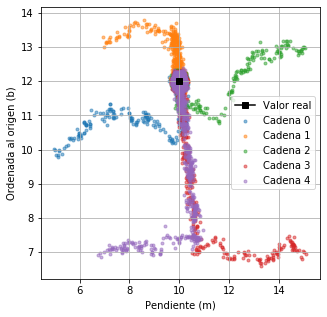

In [16]:
#Queremos visualizar las cadenas
verCadenasMarkov(cadenas=cadenas, realPoint=theta)

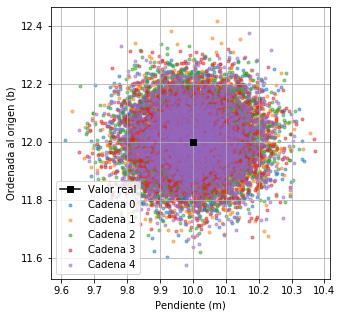

In [17]:
# Hagámosle un zoom a la zona de mayor densidad de puntos
verCadenasMarkov(cadenas=cadenas, realPoint=theta, corte=500)

Quremos conocer la tasa de aceptación para saber si estamos haciendo bien las cosas

In [123]:
# Conocer la tasa de aceptación
for index, accepted in enumerate(tasaAceptada):
    print(f"La tasa de rechazo de la cadena {index} es: {accepted}")

La tasa de rechazo de la cadena 0 es: 0.02125
La tasa de rechazo de la cadena 1 es: 0.0145
La tasa de rechazo de la cadena 2 es: 0.021
La tasa de rechazo de la cadena 3 es: 0.0275
La tasa de rechazo de la cadena 4 es: 0.03


Visualicemos como es que varían los parámetros con el número de pasos

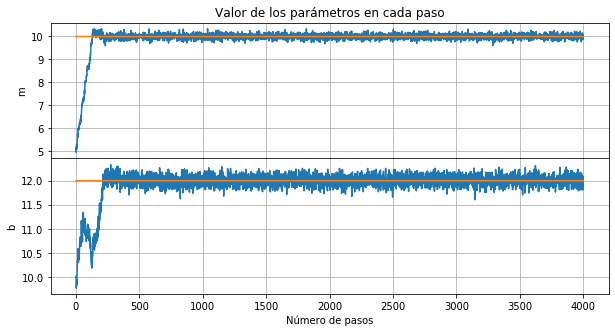

In [19]:
graphParameters(cadena=cadenas[0], labels=["m","b"])

Note que las gráficas están muy alejadas de lo que deseamos reportar, podemos aplicar un "burning" o algo para que se vea más cerca lo que queremos, en el caso de la ordenada al origen aplicaremos un burning en el paso 1000 al igual que a la pendiente

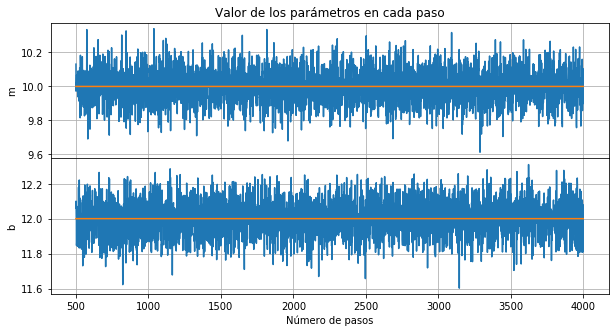

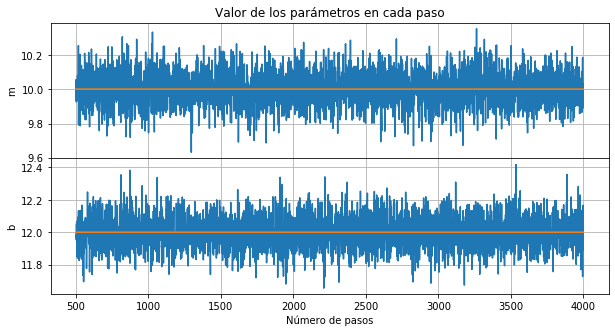

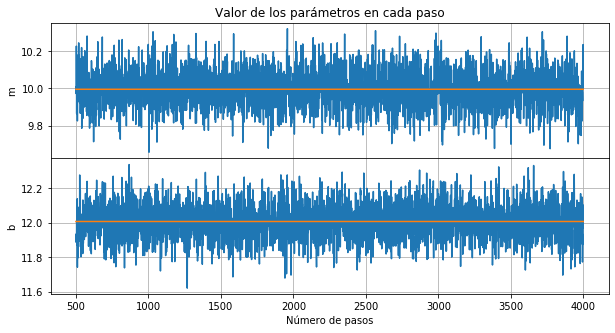

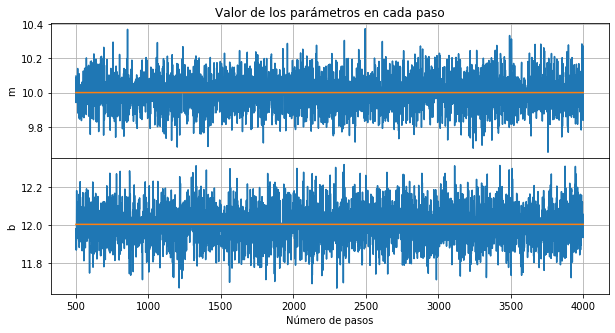

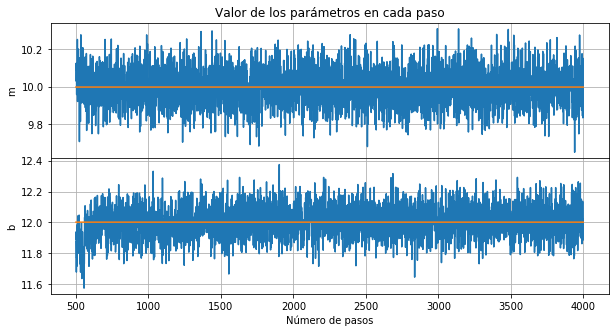

In [20]:
# Lo haré con todas las cadenas:
for index in range(5):
    graphParameters(cadena=cadenas[index], labels=["m","b"], corte=500)

Es interesante ahora, hacer gráficos triangulares, para más claridad en los parámetros, aquí juntamos los resultados de todas las cadenas y las comparamos 

Removed no burn in


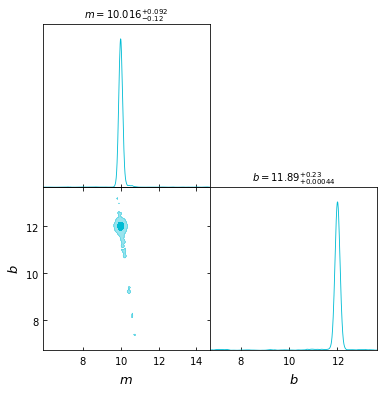

In [18]:
trianglePlot(cadenas=cadenas, corte=0, labels=["m","b"])

Le agregamos un bonito burning y obtenemos:

Removed no burn in


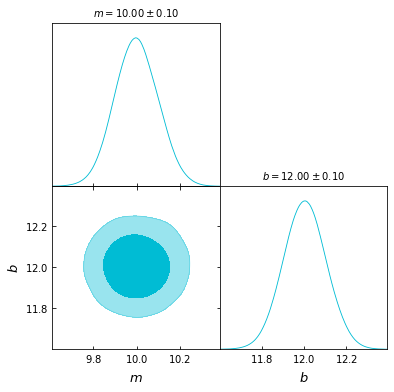

In [19]:
trianglePlot(cadenas=cadenas, corte=500, labels=["m","b"])

Hacemos lo mismo pero con un histograma en 2d

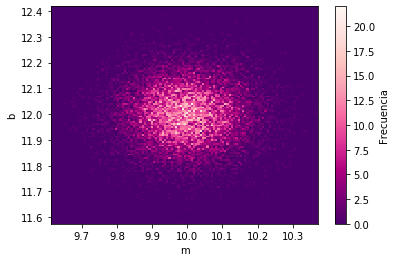

In [20]:
plotHist2d(cadenas=cadenas, parametros=[0,1], bins=120, labels = ["m","b"], corte=500)

Realmente necesitamos saber si las cadenas convergen, así que aplicamos el diagnóstico gelman rubin

In [177]:
gelmanRubin(cadenas)

El diagnóstico resultante del parámetro 0 es: 1.01161
El diagnóstico resultante del parámetro 1 es: 1.02441


Nuestros resultados son cercanos a 1, eso es un indicio de que nuestras cadenas convergen muy bien :)